In [132]:
using LinearAlgebra
using Arpack
using Plots
using SparseArrays
using Combinatorics

# Automata method for SOW on the square lattice

In this notebook, we explore the code used to find upper bounds for the connective constant of self-osculating walks (SOWs) on the square lattice.  
This code implements the method explained in Section 3 of [our work](https://arxiv.org/pdf/2509.04568) and is used to compute the upper bounds reported in **Table 4**.

The main idea is to adapt the automata method of Pönitz and Tittmann (2000)[^1] to construct a transfer matrix $M_{\leq k}$ that counts walks of length $n$ without loops of size $\leq k$.

[^1]: Pönitz, A., & Tittmann, P. (2000). *Improved Upper Bounds for Self-Avoiding Walks in $\mathbb{Z}^d$*. *The Electronic Journal of Combinatorics*, 7, R21. [PDF](https://www.combinatorics.org/ojs/index.php/eljc/article/view/v7i1r21)

# Plots

Below, we show code to plot a single walk, a list of walks, and the allowed vertices in self-osculating walks (SOWs).

In [133]:
"""
plot_walk(walk)

Plot a single walk in a separate figure using quiver for better arrows.

Arguments
walk: A collection of coordinates representing the path of the walk. Each element should be a tuple (x, y) or similar.

Returns
Nothing. The function produces a plot of the walk.
"""

function plot_walk(walk)
    x = [w[1] for w in walk]
    y = [w[2] for w in walk]

    fig = plot(x, y, marker=:circle, color=:blue, linewidth=2, markersize=5,
               xlabel="X", ylabel="Y", label="Path")  # main path

    # Start and end points
    scatter!(fig, [x[1]], [y[1]], color=:green, markersize=8, label="Start")
    scatter!(fig, [x[end]], [y[end]], color=:red, markersize=8, label="End")

    # Quiver arrows along the path
    dx = diff(x)
    dy = diff(y)
    quiver!(fig, x[1:end-1], y[1:end-1], quiver=(dx, dy), color=:blue, label="")

    # Annotate step numbers at midpoints
    for i in 1:length(dx)
        mid_x = (x[i] + x[i+1]) / 2
        mid_y = (y[i] + y[i+1]) / 2
        annotate!(fig, mid_x, mid_y + 0.1, text("$i", 10, :black))
    end

    display(fig)
end



"""
plot_all_walks(walks)

Plot each walk in a separate figure.

Arguments
walks: A collection (e.g., array) of walks, where each walk is a collection of coordinates (tuples of x, y).

Returns
Nothing. The function produces one figure per walk.
"""
function plot_all_walks(walks)
    if isempty(walks)
        println("No valid walks found.")
        return
    end

    for walk in walks
        plot_walk(walk)  # Plot each walk
    end
end

plot_all_walks

In [134]:
"""
plot_vertices(allowed_vertices, x, y)

Plot allowed vertices around a given point (x, y). Each set of vertices is displayed in a separate figure with colored segments and a square centered at (x, y).

Arguments
allowed_vertices: A collection of vertex sets to plot.
x: The x-coordinate of the central reference point.
y: The y-coordinate of the central reference point.

Returns
Nothing. The function produces a plot for each vertex set.
"""
function plot_vertices(allowed_vertices,x,y)

    colors = [:red, :blue, :orange]
    
    # Square
    angles = [2π * k / 4 for k in 0:3]
    xs = [x+cos(θ) for θ in angles]
    ys = [y+sin(θ) for θ in angles]

    push!(xs, xs[1])
    push!(ys, ys[1])
    for vertex_set in allowed_vertices
        plt = plot(legend = false)
        for (i, s) in enumerate(vertex_set)
            points = collect(s)
            color = colors[mod1(i, length(colors))]
            if length(points) == 2
                x_coords_1 = [points[1][1], x]
                y_coords_1 = [points[1][2], y]
                x_coords_2 = [x, points[2][1]]
                y_coords_2 = [y, points[2][2]]
                plot!(x_coords_1, y_coords_1, lw=2, color=color)
                plot!(x_coords_2, y_coords_2, lw=2, color=color)
                plot!(xs, ys, lw = 2, aspect_ratio = :equal, legend = false, color = RGB(0.282, 0.863, 0.655))
            else
                error("Segment not found")
            end
        end
        display(plt)
    end
end

plot_vertices

# Allowed vertices

Below we define the allowed vertices in SOW on the square lattice and we plot them.

In [135]:
"""
rotate_point(x, y, n)

Rotate a point (x, y) by n * 90 degrees (pi/2 radians) counterclockwise.

Arguments
x: The x-coordinate of the point.
y: The y-coordinate of the point.
n: The number of 90-degree rotations to apply.

Returns
A tuple (xrot, yrot) representing the rotated point as integers.
"""
function rotate_point(x, y, n)
    return (Int(round(x*cos(n*pi/2) - y*sin(n*pi/2))),
            Int(round(x*sin(n*pi/2) + y*cos(n*pi/2))))
end

rotate_point

In [136]:
vertex_1 = Set([Set([(-1, 0),(0, 1)]), Set([(1, 0),(0, -1)])]) 

vertex_2 = Set([Set([(-1, 0),(1, 0)])]) 


allowed_vertices = Set([vertex_1,vertex_2])
for vertex_set in copy(allowed_vertices)
    for a in 1:3
        rotated_coords = Set([Set([rotate_point(x, y, a) for (x, y) in s]) for s in vertex_set])
        push!(allowed_vertices, rotated_coords)
    end

    for a in 0:3
        rotated_coords = Set([Set([rotate_point(x, -y, a) for (x, y) in s]) for s in vertex_set])
        push!(allowed_vertices, rotated_coords)
    end
end

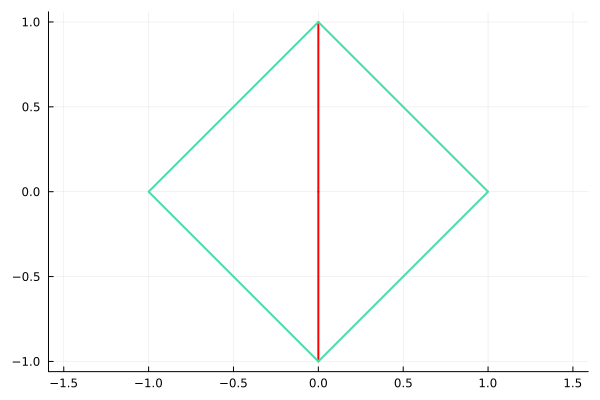

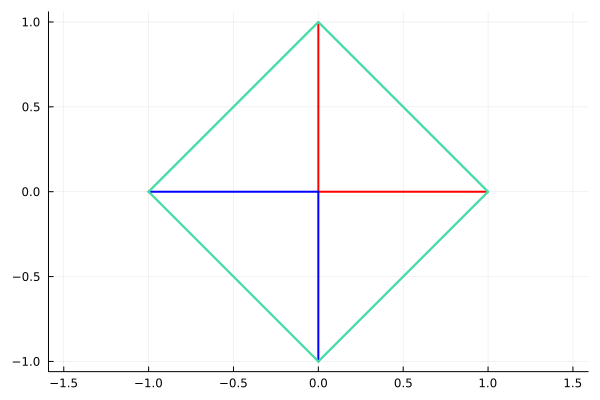

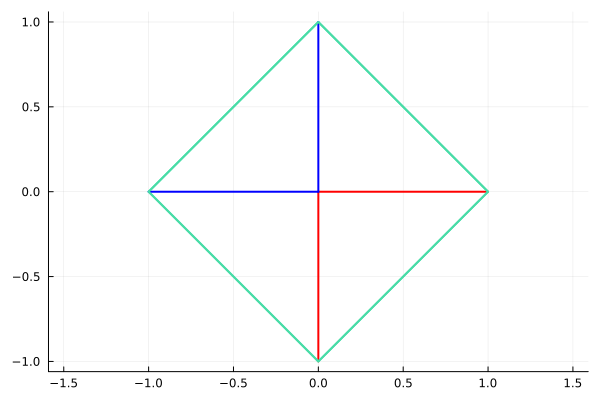

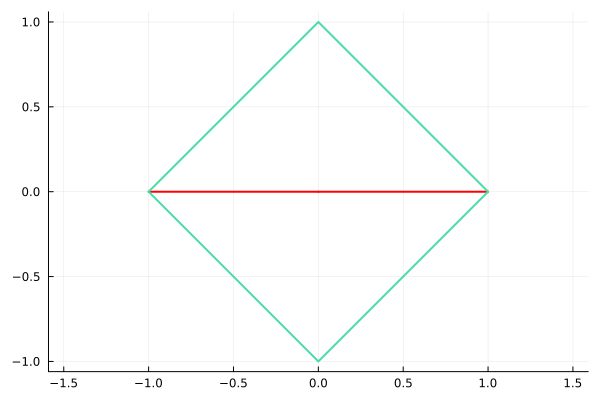

In [137]:
plot_vertices(collect(allowed_vertices),0,0)

# Generic functions

Below, we define some generic functions that will be used later to build the transfer matrix.

In [138]:
"""
has_valid_matching(l, S)

Check if there exists a permutation of the collection S such that each element of l is a subset of the corresponding element in S.

Arguments
l: A collection of sets to match.
S: A collection of sets to match against.

Returns
true if there exists a permutation of S where each element of l is a subset of the corresponding element; false otherwise.
"""

function has_valid_matching(l, S)

    l_list = collect(l)
    S_list = collect(S)
    if length(l_list)>length(S_list)
        return false
    end
    for perm in permutations(S_list)
        if all(issubset(li, si) for (li, si) in zip(l_list, perm))
            return true
        end
    end
    return false
end

has_valid_matching (generic function with 1 method)

In [139]:
"""
shifted_allowed_vertices(allowed_vertices, x, y)

Shift all vertex sets in allowed_vertices from origin (0,0) to (x,y).

Arguments
allowed_vertices: A nested collection of sets of vertex coordinates.Each innermost set contains tuples (i, j) representing points.
x: Horizontal shift amount.
y: Vertical shift amount.

Returns
A new Set containing all shifted vertices, preserving the original nested structure.
"""

function shifted_allowed_vertices(allowed_vertices, x, y)

    # shift the allowed_vertices location from (0,0) to (x,y)

    shifted = Set([])
    for vertex_set in allowed_vertices
        shifted_vertex_set = Set([])
        for set in vertex_set
            push!(shifted_vertex_set, Set([(loc[1]+x,loc[2]+y) for loc in set]))
        end
        push!(shifted, shifted_vertex_set)
    end
    return shifted
end

shifted_allowed_vertices (generic function with 1 method)

In [140]:
"""
is_allowed_vertex(path, new_x, new_y)

Determine if a path together with a candidate new step (new_x, new_y) is allowed.

Arguments
path: A collection of vertices or coordinates representing the current path.
new_x: The x-coordinate of the candidate new vertex.
new_y: The y-coordinate of the candidate new vertex.

Returns
true if the new vertex can be added to the path according to the rules.
false otherwise.
"""
function is_allowed_vertex(path,new_x,new_y)

    x,y = path[end]

    indices = findall(z -> z == (x,y), path)[1:end-1]
    indices_new = findall(z -> z == (new_x,new_y), path)

    allowed_vertices_xy = shifted_allowed_vertices(allowed_vertices,x,y)

    allowed_vertices_new_x_new_y = shifted_allowed_vertices(allowed_vertices,new_x,new_y)

    if (new_x,new_y) == path[end-1] #No going back
        return false
    end

    if count(p -> p == (new_x, new_y), path) == 2   # A vertex cannot be visited >2 times
        return false
    end

    #Check allowed paths wrt (x,y)

    vertex_set = Set{Any}([Set([path[end-1],(new_x,new_y)])]) #vertex_set related to (x,y)
    for idx in indices
        if idx>1
            push!(vertex_set, Set([path[idx-1],path[idx+1]]))
        else
            push!(vertex_set, Set([path[idx+1]])) #origin
        end
    end

    list = collect(allowed_vertices_xy)

    is_valid = any(has_valid_matching(vertex_set, allowed_vertex_set) for allowed_vertex_set in allowed_vertices_xy)

    #Check allowed paths wrt (new_x,new_y)

    vertex_set_new = Set([Set([(x,y)])]) #vertex_set related to (new_x,new_y)

    for idx in indices_new
        if idx>1
            push!(vertex_set_new, Set([path[idx-1],path[idx+1]]))
        else
            push!(vertex_set_new, Set([path[idx+1]])) #origin
        end
    end


    is_valid *= any(has_valid_matching(vertex_set_new, allowed_vertex_set) for allowed_vertex_set in allowed_vertices_new_x_new_y)


    return is_valid
end

is_allowed_vertex

# Loops of size $k$

Below, we define a function that finds all loops of size $k$ up to reflection and rotation. 
The first move is always forced to the right, and any path that can be reflected along the x-axis is neglected.

In [141]:
"""
find_loops(k)

Find all loops of size k (up to reflection/rotation)

Arguments
k: Size of the loop

Returns
List of loops of size k
"""
function find_loops(k)

    if k == 2
        return [[(0, 0), (1, 0), (0, 0)]]
    end

    moves =  [(1, 0), (-1,0),(0,1),(0,-1)]

    solutions = []

    function backtrack(path)
        if length(path) == k + 1
            push!(solutions, copy(path))
            return
        end
        x, y = path[end]  # Get current position
        subpath_less_k = path[max(1, length(path) - (k - 2)):end] #partial path

        for (dx, dy) in moves
            new_x, new_y = x + dx, y + dy

            if (x,y) == (length(path)-1,0) && dy<0 # Skip paths that can be reflected along x to speed up code later
                continue
            end

            if !is_allowed_vertex(subpath_less_k, new_x, new_y) #Skip all invalid paths wrt to the partial path
                continue
            end

            
            # Keep loops of size k
            if length(path) >= k && is_allowed_vertex(path, new_x, new_y)
                continue
            end

            
            push!(path, (new_x, new_y))
            backtrack(path)
            pop!(path)  # Backtrack
        end
    end

    # Start backtracking from different initial directions
    backtrack([(0.0, 0.0), (1.0, 0.0)])

    return solutions
end


find_loops

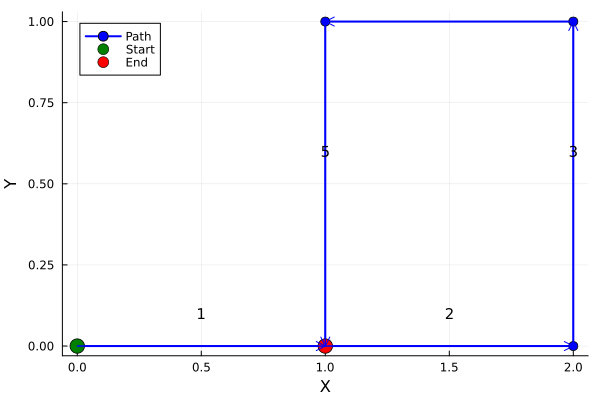

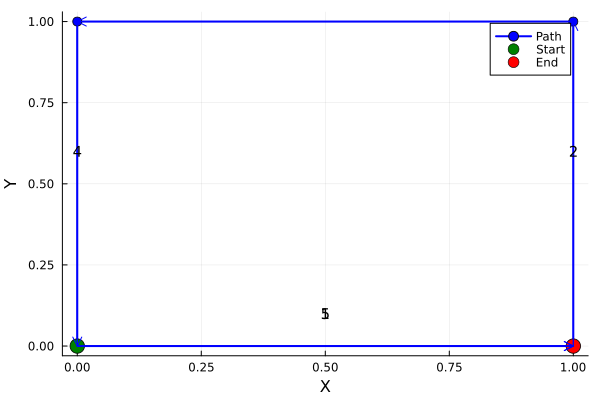

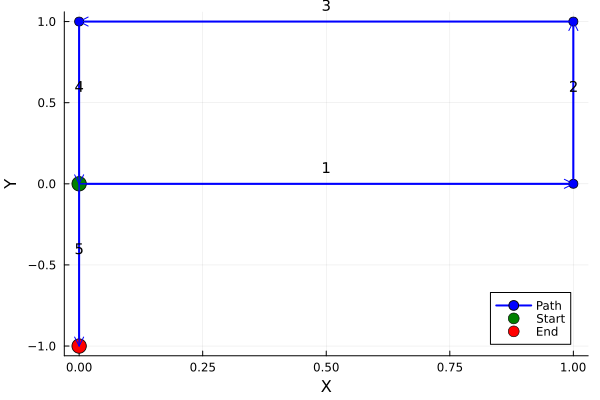

In [142]:
#Plot of loops of size 5 in SOW

loops_5 = find_loops(5)

plot_all_walks(loops_5)

# Generic functions II

In [143]:
"""
evolve(path)

Generate all possible one-step evolutions of a self-osculating walk (SOW) from the current path.

Arguments
path: A collection of coordinates representing the current walk.

Returns
A collection of new paths, each representing a valid one-step extension of the current path.
"""

function evolve(path)
    moves =  [(1, 0), (-1,0),(0,1),(0,-1)]
    solutions = []  # List of valid paths
    x, y = path[end]  # Get current position
    
    path_length = length(path)

    # Precompute the index of the current position in path for later use
    idx_current_pos = findfirst(p -> p == (x, y), path)

    for (dx, dy) in moves
        new_x, new_y = x + dx, y + dy

        if !is_allowed_vertex(path, new_x, new_y) #Skip all invalid paths
                continue
        end

        # Create new path and add to solutions
        new_path = copy(path)  # Create a copy of the current path
        push!(new_path, (new_x, new_y))  # Add the new position to the path
        push!(solutions, new_path)  # Store the new valid path
    end

    return solutions
end

evolve (generic function with 1 method)

In [144]:
"""
chop_loop(loop)

Generate all proper prefixes (subpaths keeping the starting point) of a loop.

Arguments
loop: A collection representing a loop (e.g., an array of coordinates or elements).

Returns
A vector of sub-loops, where each sub-loop is a prefix of the original loop.
"""
function chop_loop(loop)
    chopped_loop = Vector{Any}()
    for n in 2:length(loop)-1 
        push!(chopped_loop, loop[1:n]) 
    end
    return chopped_loop
end


chop_loop

In [145]:
"""
rotations_reflection(path)

Return all unique rotations and reflections of a given path.

Arguments
path: A collection of coordinates representing the original path (each coordinate is a tuple (x, y)).

Returns
A collection of paths, each being a unique rotation or reflection of the original path.
"""
function rotations_reflection(path)
    rotation_path = [path]

    # Add rotations by 90, 180, 270 degrees
    for a in 1:3
        push!(rotation_path, [rotate_point(x, y, a) for (x, y) in path])
    end
    
    # Add reflections across the x-axis and their rotations
    for a in 0:3
        push!(rotation_path, [rotate_point(x, -y, a) for (x, y) in path])
    end

    return unique(rotation_path)
end

rotations_reflection

In [146]:
"""
equivalence_k(path, subloops)

Determine which sub-loop a given path is equivalent to.

Arguments
path: A collection of coordinates representing the current path.
subloops: A collection of sub-loops against which to check equivalence.

Returns
The index of the sub-loop in subloops to which path is equivalent. Returns nothing if no equivalent sub-loop is found.
"""
function equivalence_k(path, subloops)
    for n in 1:length(path)-1
        offset = path[n]
        path_translated = [(x - offset[1], y - offset[2]) for (x, y) in path[n:end]]
        
        for rotated in rotations_reflection(path_translated)
            if haskey(subloops, rotated)
                return rotated 
            end
        end
    end
    return nothing
end

equivalence_k

# Transfer matrix

Below, we define the functions that generate the transfer matrix $M_{\leq k}$ (`automata(k)`) and `approximate_mu(k)`, which finds its largest eigenvalue.

In [147]:
"""
automata(k)

Build the transfer matrix to count paths that avoid loops of size less than or equal to k.

Arguments
k: An integer specifying the maximum loop size to avoid.

Returns
A sparse matrix used to count all valid paths without loops of size ≤ k efficiently.
"""
function automata(k)
    loop_list = [loop for n in 5:2:k for loop in find_loops(n)]


    chopped_loop_list = unique(vcat([chop_loop(loop) for loop in loop_list]...))

    subloops = Dict(loop => idx for (idx, loop) in enumerate(chopped_loop_list))
    
    matrix = spzeros(UInt8, length(subloops), length(subloops))

    for index in 1:length(chopped_loop_list)
        chopped_loop = chopped_loop_list[index]
        for path in evolve(chopped_loop)
            equivalent_state = equivalence_k(path, subloops)
            if equivalent_state !== nothing
                index_equivalent_state = subloops[equivalent_state]
                matrix[index_equivalent_state, index] +=1
            end
        end
    end

    return matrix
end


automata

In [148]:
"""
approximate_mu(k)

Estimate the connectivity (growth constant) for walks that avoid loops of size less than or equal to k.

Arguments
k: An integer specifying the maximum loop size to avoid.

Returns
A numerical value representing the approximate connectivity of the walk.
"""
function approximate_mu(k)
    vals, _ = eigs(automata(k), nev=1, which=:LM, maxiter=10000, tol=1e-9)

    return vals[1]
    
end

approximate_mu

In [149]:
approximate_mu(5)

2.8605494282683805 + 0.0im